In [1]:
%matplotlib inline

import torch
import torchvision
from torch import nn
import numpy 
import matplotlib.pyplot as plt
import time
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam

from torch.optim import Adam



In [2]:

def load_MNIST(data_transform, train=True):
    return torchvision.datasets.MNIST(
        root='./data',
        train=train,
        download=True,
        transform=data_transform
    )

def load_transformed_MNIST(img_size, batch_size, train=True):
    data_transforms = [
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),  # Scales data into [0,1]
        transforms.RandomHorizontalFlip(),
        transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
    ]
    data_transform = transforms.Compose(data_transforms)
    data = load_MNIST(data_transform, train)
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
    return data, dataloader


In [3]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
train_data, train_dataloader = load_transformed_MNIST(28, 64, train=True)
test_data, test_dataloader = load_transformed_MNIST(28, 64, train=False)


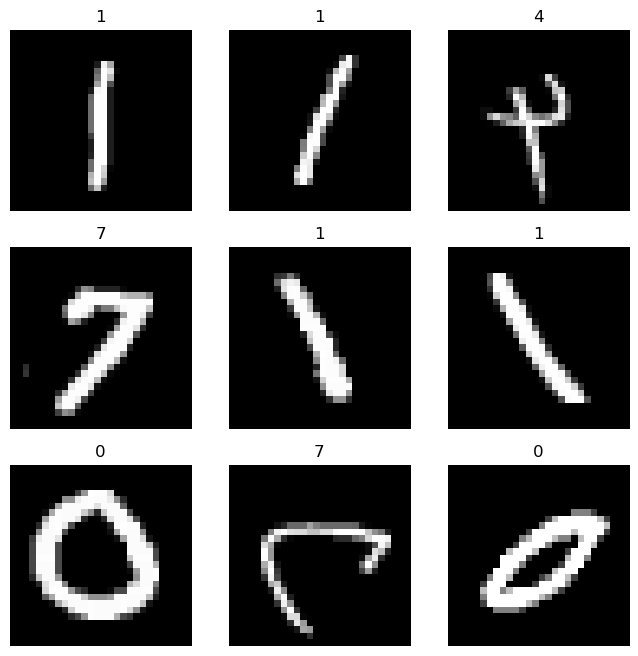

In [5]:
figure=plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataloader), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x


In [7]:
loss_fn=nn.CrossEntropyLoss()

In [8]:
model = torch.compile(NonlinearClassifier().to(device))

In [9]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            x=X.to(device)
            y=y.to(device)
            pred = model(x)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size
    
    accuracy = 100*correct
    return accuracy, loss


In [10]:

model = torch.compile(NonlinearClassifier().to(device))


In [11]:
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 3
ncols = 15  # Should evenly divide T

model.train()
for epoch in range(epochs):
    for step, (x,y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        x = x.to(device)
        y=y.to(device)
        pred = model(x)
        loss=loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        if step % 100 == 0:
            accuracy, loss = evaluate(train_dataloader, model, loss_fn)
            val_accuracy, val_loss = evaluate(test_dataloader, model, loss_fn)
            # Print the progress with train and test accuracy
            print(f"Epoch [{epoch+1}/{epochs}], Step [{step}], Loss: {loss:.4f}, Accuracy: {accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
            



No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


Epoch [1/3], Step [0], Loss: 2.2857, Accuracy: 10.57%, Val Loss: 2.2870, Val Accuracy: 10.15%
Epoch [1/3], Step [100], Loss: 0.7839, Accuracy: 73.88%, Val Loss: 0.7559, Val Accuracy: 74.67%
Epoch [1/3], Step [200], Loss: 0.6528, Accuracy: 78.29%, Val Loss: 0.6163, Val Accuracy: 79.53%
Epoch [1/3], Step [300], Loss: 0.5709, Accuracy: 81.48%, Val Loss: 0.5402, Val Accuracy: 81.77%
Epoch [1/3], Step [400], Loss: 0.5455, Accuracy: 82.40%, Val Loss: 0.5264, Val Accuracy: 82.57%
Epoch [1/3], Step [500], Loss: 0.5158, Accuracy: 83.42%, Val Loss: 0.4946, Val Accuracy: 83.94%
Epoch [1/3], Step [600], Loss: 0.4876, Accuracy: 84.50%, Val Loss: 0.4693, Val Accuracy: 85.13%
Epoch [1/3], Step [700], Loss: 0.4658, Accuracy: 85.26%, Val Loss: 0.4454, Val Accuracy: 85.61%
Epoch [1/3], Step [800], Loss: 0.4579, Accuracy: 85.07%, Val Loss: 0.4349, Val Accuracy: 85.59%
Epoch [1/3], Step [900], Loss: 0.4330, Accuracy: 85.91%, Val Loss: 0.4139, Val Accuracy: 86.36%
Epoch [2/3], Step [0], Loss: 0.4641, Accur

torch.Size([1, 28, 28])

In [14]:
!nvidia-smi

Thu Feb 22 11:28:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   65C    P8               7W /  40W |    138MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [20]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)


{'status': 'ok', 'restart': True}